In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold

# visualization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

In [3]:
IMAGE_ROOT = "/data/ephemeral/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/data/train/outputs_json"

In [4]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [5]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [6]:
print(len(pngs))
print(len(jsons))

800
800


In [7]:
df = pd.read_csv('/data/ephemeral/hbis/logs/1024x1024.csv')

In [8]:
df

,image_name,class,rle
0,image1661144206667.png,finger-1,1684000 11 1686044 17 1688090 21 1690137 25 16...
1,image1661144206667.png,finger-2,1954393 14 1956438 19 1958484 23 1960530 27 19...
2,image1661144206667.png,finger-3,2384594 10 2386641 13 2388688 15 2390734 19 23...
3,image1661144206667.png,finger-4,797420 8 799466 13 801513 16 803559 21 805605 ...
4,image1661144206667.png,finger-5,1032977 6 1035022 12 1037068 16 1039113 20 104...
...,...,...,...
4635,image1667353928376.png,Lunate,3152845 7 3154890 22 3156936 27 3158982 35 316...
4636,image1667353928376.png,Triquetrum,3050332 16 3052378 21 3054425 23 3056471 27 30...
4637,image1667353928376.png,Pisiform,3119986 7 3122028 20 3124073 28 3126119 31 312...
4638,image1667353928376.png,Radius,3202172 12 3204216 17 3206259 23 3208302 30 32...


In [9]:
list(pngs)[1].split("/")[1]

'image1661908973880.png'

In [10]:
image_dict = {name.split("/")[1]:name for name in list(pngs)}
label_dict = {name.split("/")[1][:-4]+'png':name for name in list(jsons)}

In [11]:
image_dict

{'image1664156819527.png': 'ID286/image1664156819527.png',
 'image1661908973880.png': 'ID122/image1661908973880.png',
 'image1665540658823.png': 'ID406/image1665540658823.png',
 'image1661736410568.png': 'ID073/image1661736410568.png',
 'image1664935429454.png': 'ID360/image1664935429454.png',
 'image1666746376659.png': 'ID498/image1666746376659.png',
 'image1664241629103.png': 'ID311/image1664241629103.png',
 'image1661908266164.png': 'ID116/image1661908266164.png',
 'image1666055144561.png': 'ID415/image1666055144561.png',
 'image1666575184545.png': 'ID460/image1666575184545.png',
 'image1666060263572.png': 'ID435/image1666060263572.png',
 'image1664154988975.png': 'ID276/image1664154988975.png',
 'image1661908185790.png': 'ID115/image1661908185790.png',
 'image1666575957671.png': 'ID464/image1666575957671.png',
 'image1661736699353.png': 'ID074/image1661736699353.png',
 'image1661216971933.png': 'ID015/image1661216971933.png',
 'image1665537645143.png': 'ID392/image1665537645143.png

In [12]:
pngs

{'ID001/image1661130828152_R.png',
 'ID001/image1661130891365_L.png',
 'ID002/image1661144206667.png',
 'ID002/image1661144246917.png',
 'ID003/image1661144310162.png',
 'ID003/image1661144351691.png',
 'ID004/image1661144691792.png',
 'ID004/image1661144724044.png',
 'ID005/image1661144825412.png',
 'ID005/image1661144852117.png',
 'ID006/image1661145075929.png',
 'ID006/image1661145103549.png',
 'ID007/image1661145193855.png',
 'ID007/image1661145229731.png',
 'ID008/image1661145286692.png',
 'ID008/image1661145313061.png',
 'ID009/image1661145407161.png',
 'ID009/image1661145432967.png',
 'ID010/image1661145563354.png',
 'ID010/image1661145591320.png',
 'ID011/image1661146664360.png',
 'ID011/image1661146685158.png',
 'ID012/image1661147072358.png',
 'ID012/image1661147098202.png',
 'ID013/image1661216747360.png',
 'ID013/image1661216788592.png',
 'ID014/image1661216876670.png',
 'ID014/image1661216907060.png',
 'ID015/image1661216971933.png',
 'ID015/image1661216998230.png',
 'ID01

In [13]:
df["image_path"] = df['image_name'].apply(lambda x: image_dict[x])

In [14]:
df

,image_name,class,rle,image_path
0,image1661144206667.png,finger-1,1684000 11 1686044 17 1688090 21 1690137 25 16...,ID002/image1661144206667.png
1,image1661144206667.png,finger-2,1954393 14 1956438 19 1958484 23 1960530 27 19...,ID002/image1661144206667.png
2,image1661144206667.png,finger-3,2384594 10 2386641 13 2388688 15 2390734 19 23...,ID002/image1661144206667.png
3,image1661144206667.png,finger-4,797420 8 799466 13 801513 16 803559 21 805605 ...,ID002/image1661144206667.png
4,image1661144206667.png,finger-5,1032977 6 1035022 12 1037068 16 1039113 20 104...,ID002/image1661144206667.png
...,...,...,...,...
4635,image1667353928376.png,Lunate,3152845 7 3154890 22 3156936 27 3158982 35 316...,ID547/image1667353928376.png
4636,image1667353928376.png,Triquetrum,3050332 16 3052378 21 3054425 23 3056471 27 30...,ID547/image1667353928376.png
4637,image1667353928376.png,Pisiform,3119986 7 3122028 20 3124073 28 3126119 31 312...,ID547/image1667353928376.png
4638,image1667353928376.png,Radius,3202172 12 3204216 17 3206259 23 3208302 30 32...,ID547/image1667353928376.png


In [15]:
df["label_path"] = df['image_name'].apply(lambda x: label_dict[x])

In [16]:
df['image_name'].iloc[1]

'image1661144206667.png'

In [17]:
def rle_to_mask(rle, height, width):
    mask = np.zeros(height * width, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2] - 1
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape((height, width))

In [18]:
def mask_to_poly_seg(mask):
    points = np.argwhere(mask == 1)
    points = points[:, [1, 0]]  # (row, col) => (x, y)
    return points.tolist()

In [19]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]


In [20]:
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [21]:
df

,image_name,class,rle,image_path,label_path
0,image1661144206667.png,finger-1,1684000 11 1686044 17 1688090 21 1690137 25 16...,ID002/image1661144206667.png,ID002/image1661144206667.json
1,image1661144206667.png,finger-2,1954393 14 1956438 19 1958484 23 1960530 27 19...,ID002/image1661144206667.png,ID002/image1661144206667.json
2,image1661144206667.png,finger-3,2384594 10 2386641 13 2388688 15 2390734 19 23...,ID002/image1661144206667.png,ID002/image1661144206667.json
3,image1661144206667.png,finger-4,797420 8 799466 13 801513 16 803559 21 805605 ...,ID002/image1661144206667.png,ID002/image1661144206667.json
4,image1661144206667.png,finger-5,1032977 6 1035022 12 1037068 16 1039113 20 104...,ID002/image1661144206667.png,ID002/image1661144206667.json
...,...,...,...,...,...
4635,image1667353928376.png,Lunate,3152845 7 3154890 22 3156936 27 3158982 35 316...,ID547/image1667353928376.png,ID547/image1667353928376.json
4636,image1667353928376.png,Triquetrum,3050332 16 3052378 21 3054425 23 3056471 27 30...,ID547/image1667353928376.png,ID547/image1667353928376.json
4637,image1667353928376.png,Pisiform,3119986 7 3122028 20 3124073 28 3126119 31 312...,ID547/image1667353928376.png,ID547/image1667353928376.json
4638,image1667353928376.png,Radius,3202172 12 3204216 17 3206259 23 3208302 30 32...,ID547/image1667353928376.png,ID547/image1667353928376.json


In [22]:
def vis_val(df,idx):

    img_names = df['image_name'].unique()

    df_ = df[df['image_name']==img_names[idx]]

    image_path = df_['image_path'].iloc[0]
    
    image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
    image = image / 255.

    label_path = df_['label_path'].iloc[0]

    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    # label 파일을 읽습니다.
    with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    # 클래스 별로 처리합니다.
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label

    # to tenser will be done later
    image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
    ax[1].imshow(label2rgb(label))

    plt.show()
    # return image, label

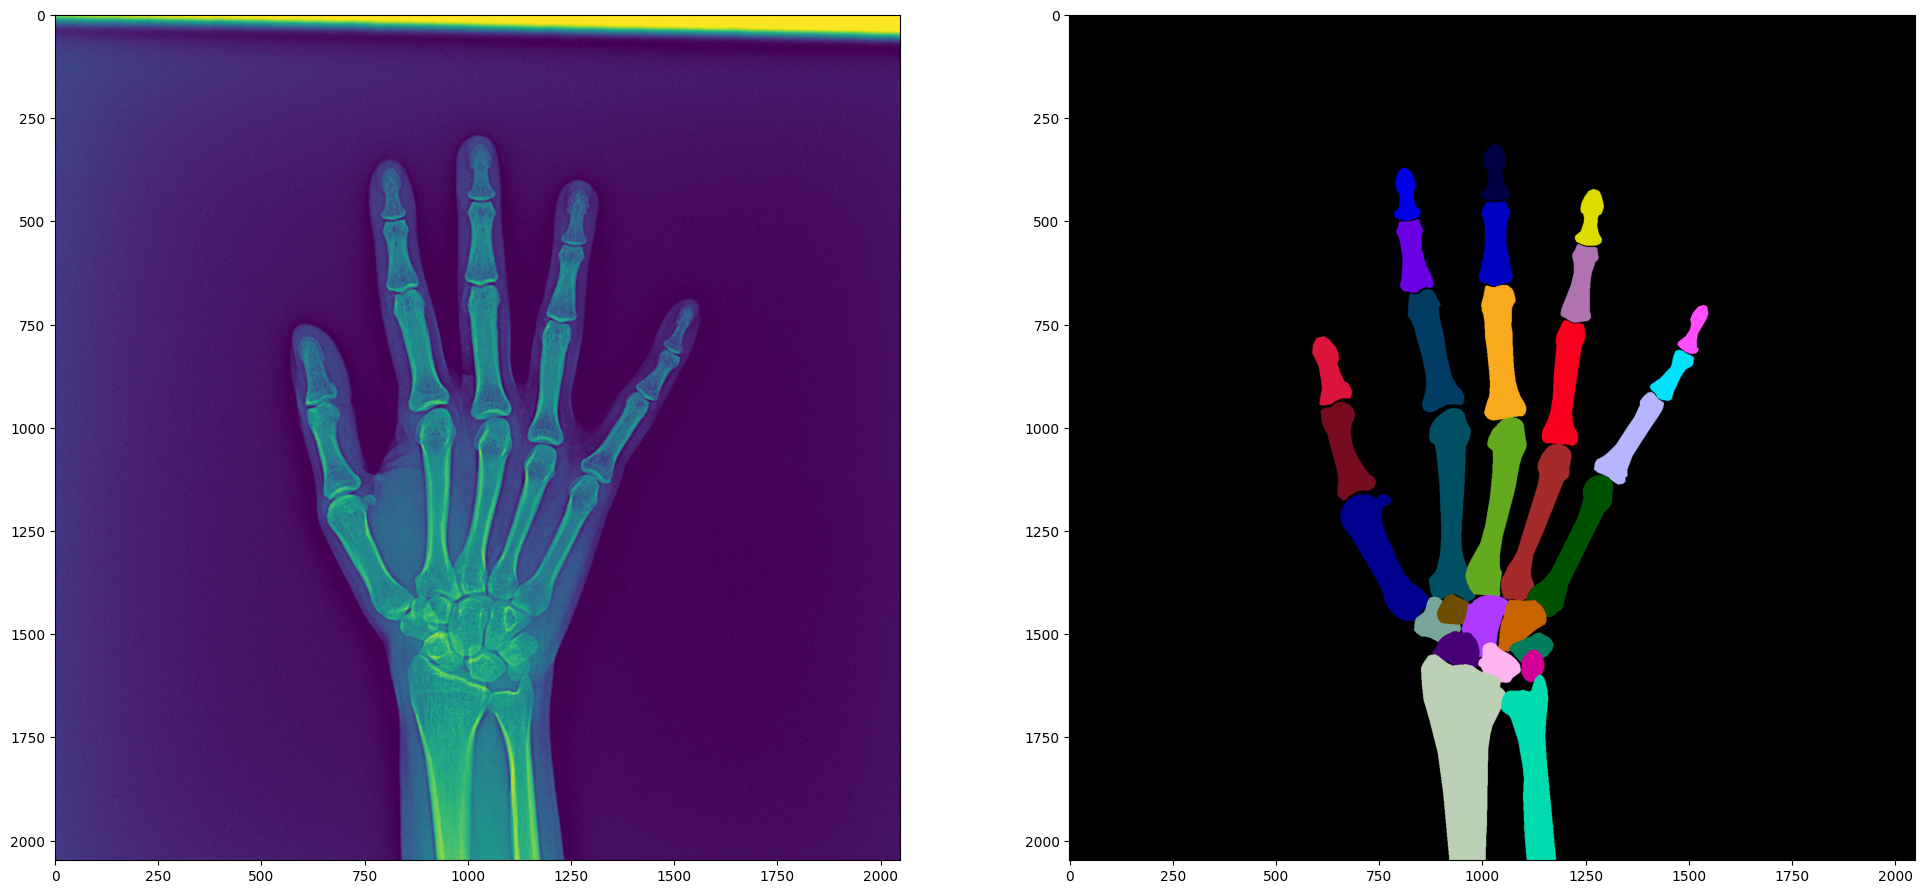

In [23]:
vis_val(df,2)

In [24]:
def vis_val_pred(df,idx):

    img_names = df['image_name'].unique()

    df_ = df[df['image_name']==img_names[idx]]

    image_path = df_['image_path'].iloc[0]
    
    image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
    image = image / 255.


    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    for index, row in df_.iterrows():
        rle = row['rle']
        class_ind = CLASS2IND[row['class']]
        mask = rle_to_mask(rle, 2048, 2048)
        label[..., class_ind] = mask


    # to tenser will be done later
    image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
    ax[1].imshow(label2rgb(label))

    plt.show()
    # return image, label

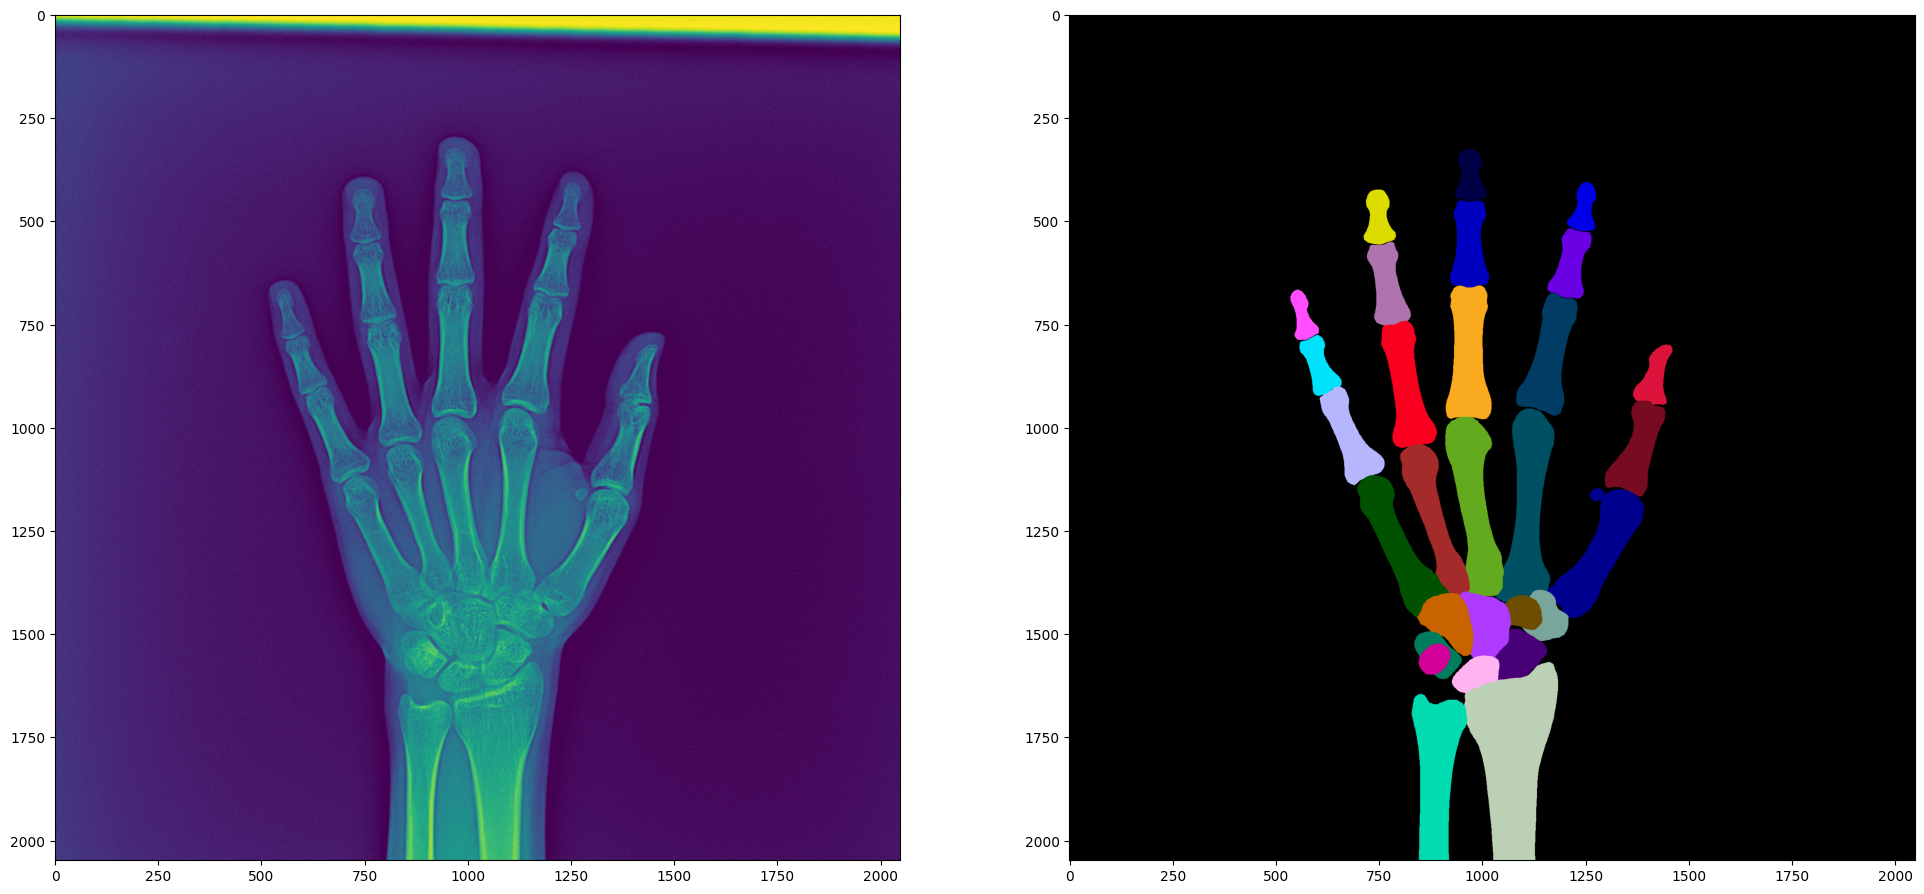

In [25]:
vis_val_pred(df,1)

In [26]:
img_names = df['image_name'].unique()
df[df['image_name']==img_names[1]]

,image_name,class,rle,image_path,label_path
29,image1661144246917.png,finger-1,1639845 4 1641888 16 1643932 22 1645978 25 164...,ID002/image1661144246917.png,ID002/image1661144246917.json
30,image1661144246917.png,finger-2,1918309 22 1920354 29 1922398 35 1924445 37 19...,ID002/image1661144246917.png,ID002/image1661144246917.json
31,image1661144246917.png,finger-3,2352380 11 2354427 14 2356473 17 2358519 20 23...,ID002/image1661144246917.png,ID002/image1661144246917.json
32,image1661144246917.png,finger-4,834786 12 836830 17 838876 20 840923 22 842970...,ID002/image1661144246917.png,ID002/image1661144246917.json
33,image1661144246917.png,finger-5,1064122 8 1066168 13 1068215 16 1070262 19 107...,ID002/image1661144246917.png,ID002/image1661144246917.json
34,image1661144246917.png,finger-6,1383572 3 1385615 10 1387661 15 1389708 19 139...,ID002/image1661144246917.png,ID002/image1661144246917.json
35,image1661144246917.png,finger-7,1956947 16 1958993 22 1961038 27 1963084 32 19...,ID002/image1661144246917.png,ID002/image1661144246917.json
36,image1661144246917.png,finger-8,668613 11 670657 19 672702 24 674747 29 676794...,ID002/image1661144246917.png,ID002/image1661144246917.json
37,image1661144246917.png,finger-9,924595 4 926641 10 926683 11 928688 16 928725 ...,ID002/image1661144246917.png,ID002/image1661144246917.json
38,image1661144246917.png,finger-10,1346483 3 1346528 6 1348524 14 1348571 14 1350...,ID002/image1661144246917.png,ID002/image1661144246917.json


In [27]:
def vis_val_comp(df,idx):

    img_names = df['image_name'].unique()

    df_ = df[df['image_name']==img_names[idx]]

    image_path = df_['image_path'].iloc[0]
    
    image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
    image = image / 255.

    label_path = df_['label_path'].iloc[0]

    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    # label 파일을 읽습니다.
    with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    # 클래스 별로 처리합니다.
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        
        matching_rows = df_[df_['class'] == c]
        for _, row in matching_rows.iterrows():
            rle = row['rle']
            mask = rle_to_mask(rle, image.shape[0], image.shape[1])
            difference_mask = (mask != class_label).astype(np.uint8)
            label[..., class_ind] = difference_mask

    # to tenser will be done later
    image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
    ax[1].imshow(label2rgb(label))

    plt.show()
    # return image, label

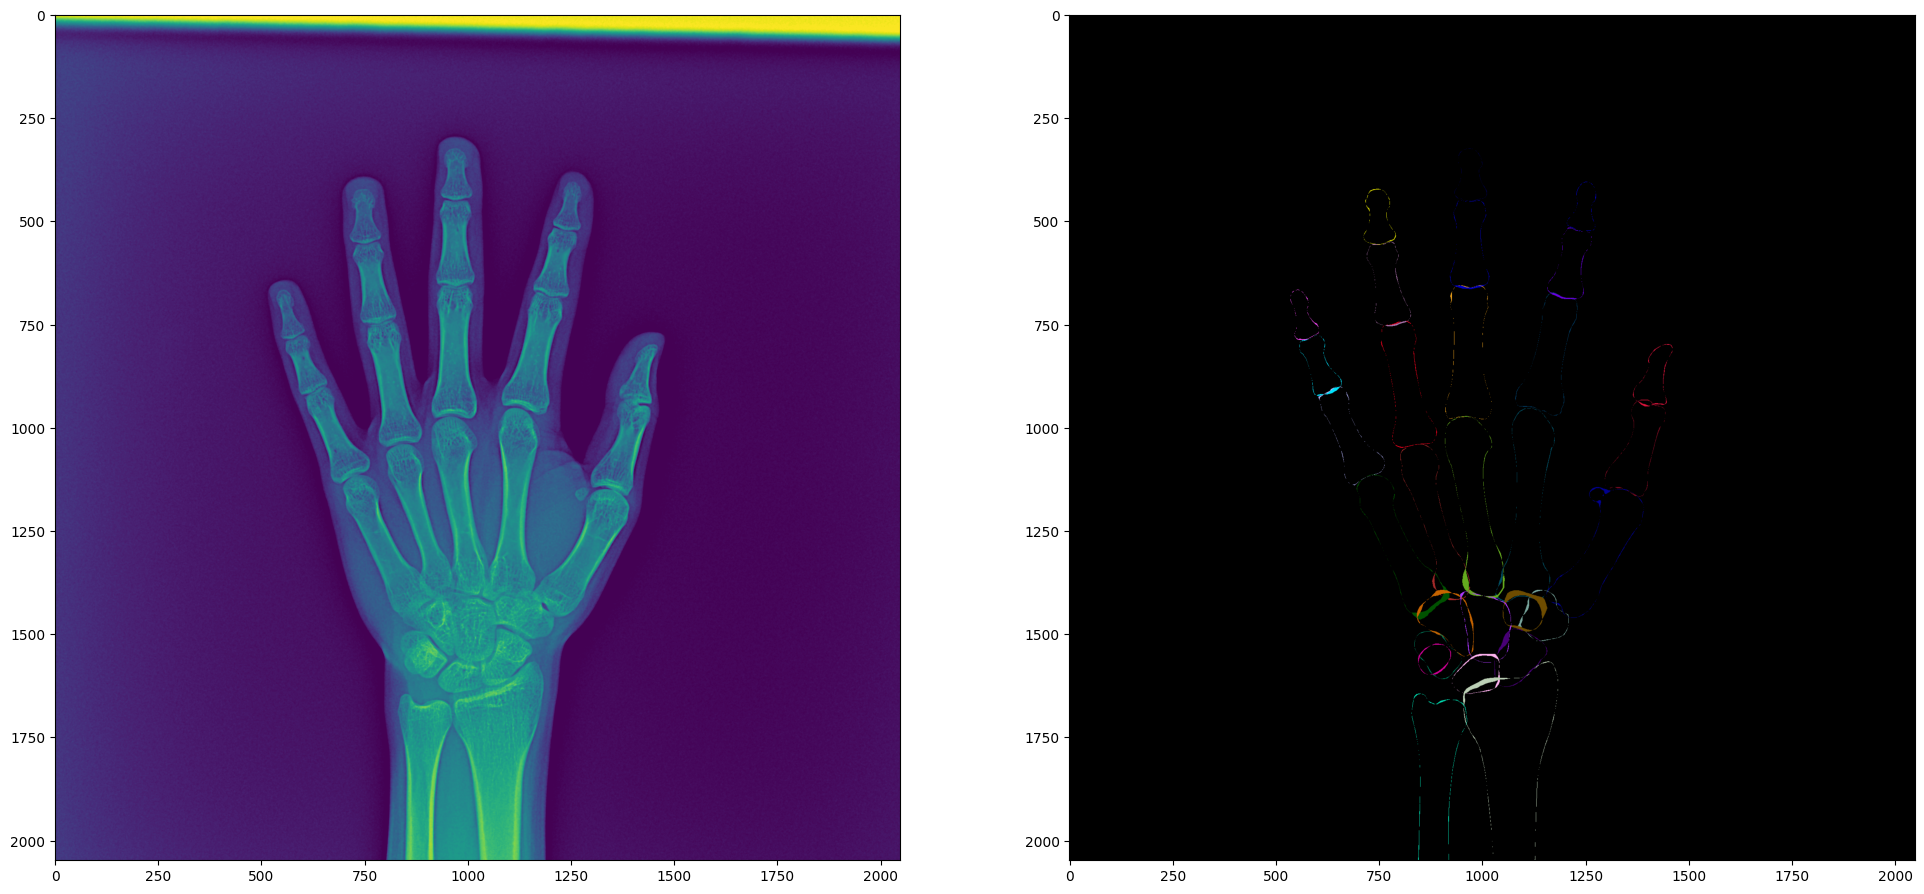

In [28]:
vis_val_comp(df,1)

## Over & Under Predict Visualization

In [29]:
import cv2
import numpy as np
import os
import json
import matplotlib.pyplot as plt

def vis_val_comp_2(df, idx):
    img_names = df['image_name'].unique()
    df_ = df[df['image_name'] == img_names[idx]]

    image_path = df_['image_path'].iloc[0]
    image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
    image = image / 255.0

    label_path = df_['label_path'].iloc[0]

    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(image.shape[:2]) + (len(CLASSES),)
    gt_label = np.zeros(label_shape, dtype=np.uint8)

    # label 파일을 읽습니다.
    with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    # GT 라벨 생성
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        gt_label[..., class_ind] = class_label

    # 예측된 마스크 생성
    pred_label = np.zeros_like(gt_label, dtype=np.uint8)
    for _, row in df_.iterrows():
        c = row['class']
        class_ind = CLASS2IND[c]
        rle = row['rle']
        
        mask = rle_to_mask(rle, image.shape[0], image.shape[1])
        pred_label[..., class_ind] = mask

    # 각 클래스에 대해 Over/Under-Prediction 계산
    over_prediction = np.zeros_like(gt_label, dtype=np.uint8)
    under_prediction = np.zeros_like(gt_label, dtype=np.uint8)
    
    # 전체 오버/언더 예측 변수 초기화
    total_over_pixels = 0
    total_under_pixels = 0

    for class_ind in range(len(CLASSES)):
        over_prediction[..., class_ind] = (pred_label[..., class_ind] > gt_label[..., class_ind]).astype(np.uint8)
        under_prediction[..., class_ind] = (pred_label[..., class_ind] < gt_label[..., class_ind]).astype(np.uint8)

        # 각 클래스에 대해 오버/언더 예측된 픽셀 수 출력
        over_pixels = np.sum(over_prediction[..., class_ind])
        under_pixels = np.sum(under_prediction[..., class_ind])
        print(f"Class {CLASSES[class_ind]}: Over-prediction = {over_pixels}, Under-prediction = {under_pixels}")

        # 전체 오버/언더 예측 픽셀 수 누적
        total_over_pixels += over_pixels
        total_under_pixels += under_pixels

    # 전체 오버/언더 예측 픽셀 수 출력
    print(f"Total Over-prediction = {total_over_pixels}, Total Under-prediction = {total_under_pixels}")

    # 각 클래스에 대해 고유한 색상 설정 (29개 색상)
    colors = plt.cm.get_cmap('tab20', len(CLASSES))  # 'tab20' 색상 맵 사용

    # 시각화를 위한 최종 이미지를 저장할 공간
    over_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float64)
    under_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float64)
    combined_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float64)

    # 각 클래스에 대해 Over/Under 시각화
    for i, class_name in enumerate(CLASSES):
        # Over-prediction: 고유 색상으로 표시
        class_color = np.array(colors(i)[:3]) * 255  # 색상 맵에서 R, G, B 값 추출
        
        over_rgb[..., 0] += over_prediction[..., i] * class_color[0]  # 빨간색 채널
        over_rgb[..., 1] += over_prediction[..., i] * class_color[1]  # 초록색 채널
        over_rgb[..., 2] += over_prediction[..., i] * class_color[2]  # 파란색 채널

        # Under-prediction: 다른 고유 색상으로 표시
        under_rgb[..., 0] += under_prediction[..., i] * class_color[0]  # 빨간색 채널
        under_rgb[..., 1] += under_prediction[..., i] * class_color[1]  # 초록색 채널
        under_rgb[..., 2] += under_prediction[..., i] * class_color[2]  # 파란색 채널

        # Combined: Over와 Under-prediction을 합침
        combined_rgb[..., 0] += over_prediction[..., i] * class_color[0]
        combined_rgb[..., 1] += over_prediction[..., i] * class_color[1]
        combined_rgb[..., 2] += over_prediction[..., i] * class_color[2]

        combined_rgb[..., 0] += under_prediction[..., i] * class_color[0]
        combined_rgb[..., 1] += under_prediction[..., i] * class_color[1]
        combined_rgb[..., 2] += under_prediction[..., i] * class_color[2]

    # 최종 이미지 타입을 uint8로 변환
    over_rgb = np.clip(over_rgb, 0, 255).astype(np.uint8)
    under_rgb = np.clip(under_rgb, 0, 255).astype(np.uint8)
    combined_rgb = np.clip(combined_rgb, 0, 255).astype(np.uint8)

    # 시각화
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))

    # Over-prediction 시각화
    ax[0].imshow(over_rgb)
    ax[0].set_title(f"Over-Predicted Pixels")

    # Under-prediction 시각화
    ax[1].imshow(under_rgb)
    ax[1].set_title(f"Under-Predicted Pixels")

    # Combined 시각화 (Over + Under)
    ax[2].imshow(combined_rgb)
    ax[2].set_title(f"Combined Over & Under-Prediction")

    plt.tight_layout()
    plt.show()


Class finger-1: Over-prediction = 225, Under-prediction = 99
Class finger-2: Over-prediction = 277, Under-prediction = 144
Class finger-3: Over-prediction = 1133, Under-prediction = 219
Class finger-4: Over-prediction = 124, Under-prediction = 69
Class finger-5: Over-prediction = 104, Under-prediction = 323
Class finger-6: Over-prediction = 80, Under-prediction = 381
Class finger-7: Over-prediction = 770, Under-prediction = 376
Class finger-8: Over-prediction = 110, Under-prediction = 64
Class finger-9: Over-prediction = 77, Under-prediction = 246
Class finger-10: Over-prediction = 243, Under-prediction = 282
Class finger-11: Over-prediction = 615, Under-prediction = 479
Class finger-12: Over-prediction = 116, Under-prediction = 70
Class finger-13: Over-prediction = 181, Under-prediction = 155
Class finger-14: Over-prediction = 180, Under-prediction = 344
Class finger-15: Over-prediction = 275, Under-prediction = 445
Class finger-16: Over-prediction = 64, Under-prediction = 96
Class fi

/tmp/ipykernel_2937316/2006866930.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(CLASSES))  # 'tab20' 색상 맵 사용


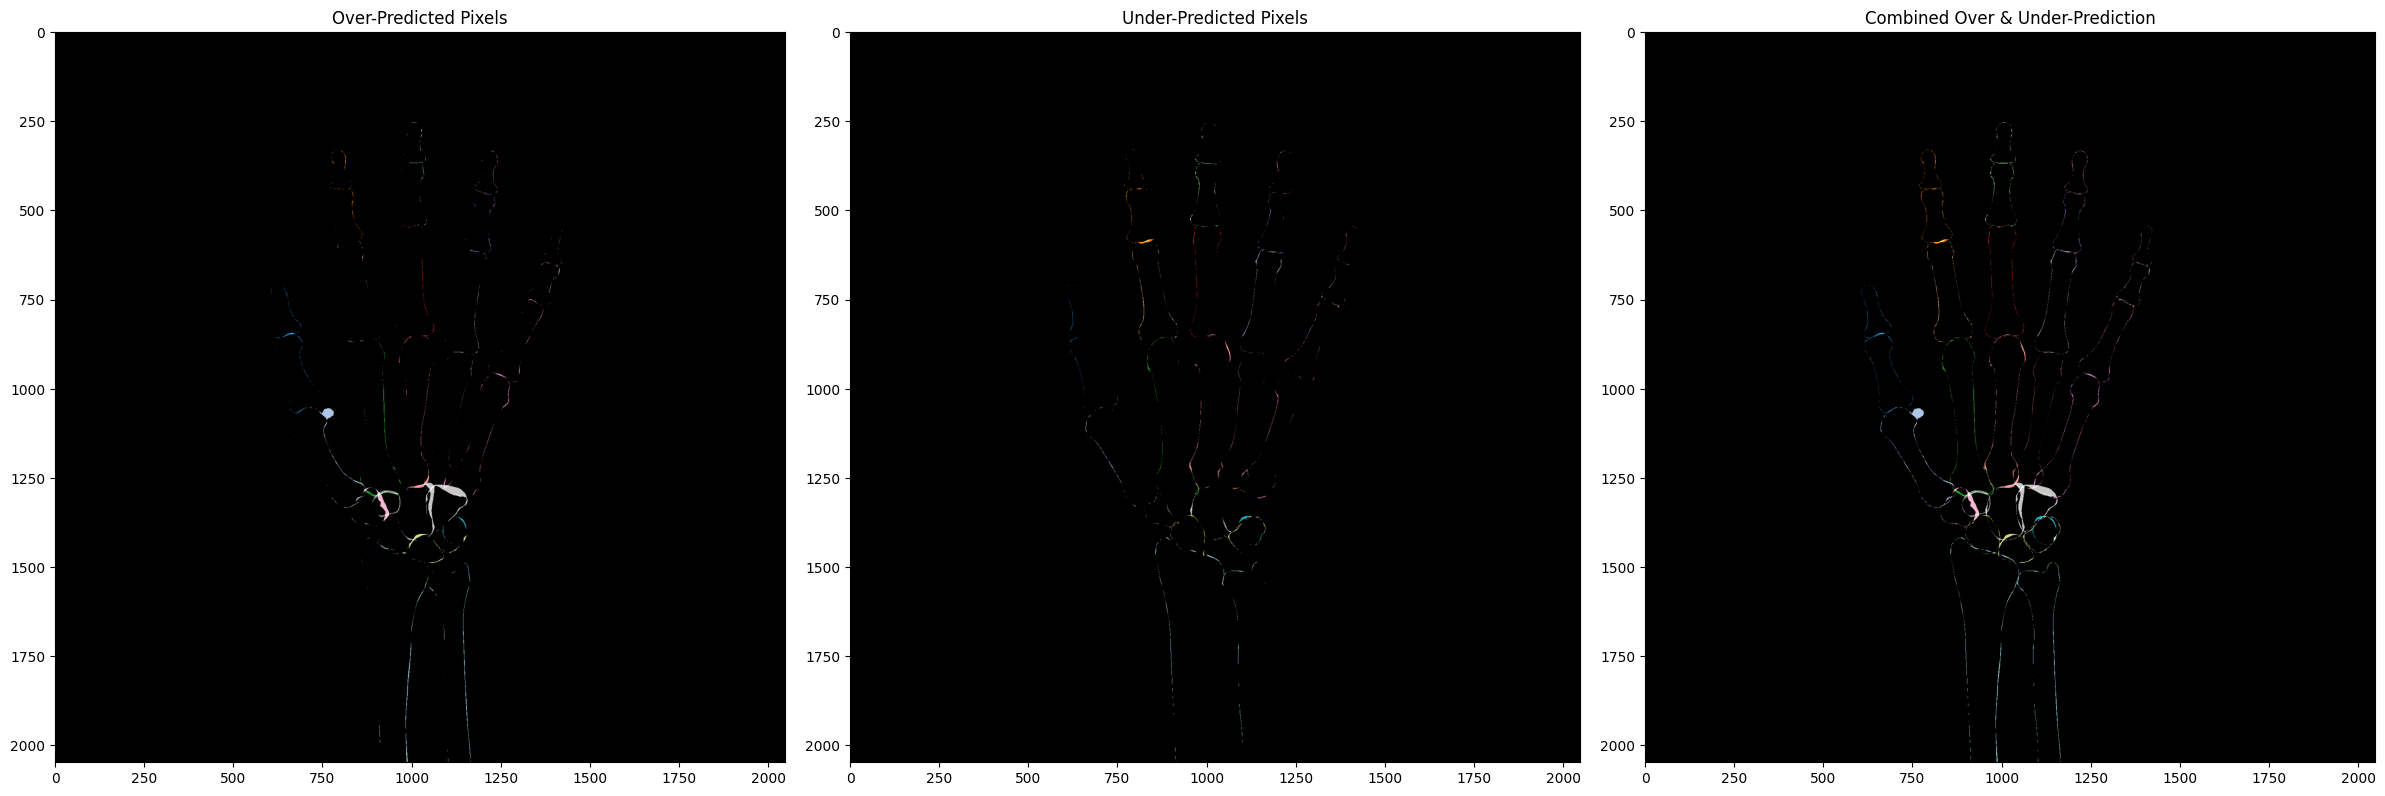

In [30]:
vis_val_comp_2(df, 18)

## 클래스 별 under & over predict 전체 validation image dataset에 대한 분포 확인

In [ ]:
def vis_val_comp_3(df):
    # 오버/언더 예측 값들을 저장할 딕셔너리
    total_class_metrics = {class_name: {"gt_pixels": 0, "over_pixels": 0, "under_pixels": 0} for class_name in CLASSES}

    # df 내의 모든 이미지에 대해 처리
    img_names = df['image_name'].unique()  # 이미지 이름 목록을 먼저 추출
    
    for idx in range(len(img_names)):  # 이제 img_names 길이를 기준으로 반복
        df_ = df[df['image_name'] == img_names[idx]]  # 해당 이미지에 대한 df 필터링

        image_path = df_['image_path'].iloc[0]
        image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
        image = image / 255.0

        label_path = df_['label_path'].iloc[0]

        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES),)
        gt_label = np.zeros(label_shape, dtype=np.uint8)

        # label 파일을 읽습니다.
        with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        # GT 라벨 생성
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            gt_label[..., class_ind] = class_label

            # GT 크기 누적
            total_class_metrics[CLASSES[class_ind]]["gt_pixels"] += np.sum(class_label)

        # 예측된 마스크 생성
        pred_label = np.zeros_like(gt_label, dtype=np.uint8)
        for _, row in df_.iterrows():
            c = row['class']
            class_ind = CLASS2IND[c]
            rle = row['rle']
            mask = rle_to_mask(rle, image.shape[0], image.shape[1])
            pred_label[..., class_ind] = mask

        # 각 클래스에 대해 Over/Under-Prediction 계산
        over_prediction = np.zeros_like(gt_label, dtype=np.uint8)
        under_prediction = np.zeros_like(gt_label, dtype=np.uint8)

        for class_ind in range(len(CLASSES)):
            over_prediction[..., class_ind] = (pred_label[..., class_ind] > gt_label[..., class_ind]).astype(np.uint8)
            under_prediction[..., class_ind] = (pred_label[..., class_ind] < gt_label[..., class_ind]).astype(np.uint8)

            # 오버/언더 픽셀 수 누적
            over_pixels = np.sum(over_prediction[..., class_ind])
            under_pixels = np.sum(under_prediction[..., class_ind])

            total_class_metrics[CLASSES[class_ind]]["over_pixels"] += over_pixels
            total_class_metrics[CLASSES[class_ind]]["under_pixels"] += under_pixels

    # 클래스별 정규화된 결과 계산
    classwise_results = []
    for class_name, metrics in total_class_metrics.items():
        gt_pixels = metrics["gt_pixels"]
        over_pixels = metrics["over_pixels"]
        under_pixels = metrics["under_pixels"]
        classwise_results.append({
            "class_name": class_name,
            "gt_pixels": gt_pixels,
            "over_pixels": over_pixels,
            "under_pixels": under_pixels,
            "over_ratio": over_pixels / gt_pixels if gt_pixels > 0 else 0,
            "under_ratio": under_pixels / gt_pixels if gt_pixels > 0 else 0,
        })

    # 클래스별 결과를 데이터프레임으로 변환
    classwise_df = pd.DataFrame(classwise_results)

    # 출력
    print(classwise_df)
    return classwise_df

# 결과 호출
classwise_distribution = vis_val_comp_3(df)


    class_name   gt_pixels  over_pixels  under_pixels  over_ratio  under_ratio
0     finger-1   1327214.0      38681.0       48256.0    0.029145     0.036359
1     finger-2   2678504.0      51273.0       53422.0    0.019142     0.019945
2     finger-3   4386379.0      68945.0       69052.0    0.015718     0.015742
3     finger-4    839042.0      21778.0       23879.0    0.025956     0.028460
4     finger-5   1606630.0      42967.0       37639.0    0.026744     0.023427
5     finger-6   3511070.0      49416.0       54738.0    0.014074     0.015590
6     finger-7   5769035.0      91926.0      103023.0    0.015934     0.017858
7     finger-8    966064.0      23412.0       24255.0    0.024234     0.025107
8     finger-9   2053124.0      41720.0       44519.0    0.020320     0.021684
9    finger-10   3927480.0      51963.0       57611.0    0.013231     0.014669
10   finger-11   5312338.0     105003.0      138896.0    0.019766     0.026146
11   finger-12    951462.0      25368.0       24744.

In [32]:
classwise_distribution.to_csv('./output.csv')